## Deep Knowledge Tracing

We will try out three different deep learning models. The code is in the folder DeepModels.

# Data

We will fit data from the Assistments platform (https://www.commonsense.org/education/website/assistments). These data are from the course 2015.

First make sure to download the data from https://drive.google.com/file/d/0B_hO8cnpcIMgUGZzRnh3bHJrSjQ/view?resourcekey=0-dGtan-IMFc3IjQ749-FgQA to the folder **./DeepModels/datasets/ASSIST2015/**. The data preparation script assumes that the data are in a file **./DeepModels/datasets/ASSIST2015/2015_100_skill_builders_main_problems.csv**.

In [1]:
# Imports
import os
import pandas as pd
import json
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
os.path.abspath(os.getcwd())
os.makedirs("DeepModels/datasets/ASSIST2015", exist_ok=True)

Inspect the data:
- *user_id* - Student ID. 
- *log_id* - Indicates the order in which it was presented.
- *sequence_id* - Knowledge Component (KC). Groups items (exercises/questions) of a similar topic or skill.
- *correct* - Whether the response is correct (1) or incorrect (0).

In [3]:
data_dir = "DeepModels/datasets/ASSIST2015"
data = pd.read_csv(
    os.path.join(data_dir, "2015_100_skill_builders_main_problems.csv"), sep=","
)

print(data.head(10))
print(data.user_id.nunique())
print(data.shape)
print(data.correct.value_counts())

   user_id     log_id  sequence_id  correct
0    50121  167478035         7014      0.0
1    50121  167478043         7014      1.0
2    50121  167478053         7014      1.0
3    50121  167478069         7014      1.0
4    50964  167478041         7014      1.0
5    50964  167478050         7014      1.0
6    50964  167478055         7014      0.0
7    50964  167478073         7014      1.0
8    50964  167478076         7014      1.0
9    50964  167478081         7014      1.0
19917
(708631, 4)
correct
1.000000    500379
0.000000    183422
0.666667     15981
0.333333      8383
0.750000       282
0.500000       101
0.250000        75
0.900000         3
0.800000         2
0.200000         2
0.100000         1
Name: count, dtype: int64


# Preprocessing

Since datasets can differ in how they are formatted. In the **data_loaders** folder there are preprocessing scripts. These are called when you run the model (no need to call them separately). We can run *train.py* with the option *--only_preprocess* to run only the preprocessing, to avoid a long wait. 

In [4]:
os.chdir("DeepModels/")

In [5]:
!python train.py --model_name=dkt --dataset_name=ASSIST2015 --only_preprocess 

Briefly, the preprocessing implements the following steps:

- Sort responses by log_id (time) for each student.
- Remove observations if correct is 1 or 0.
- Reindex students and items.
- Split sequences of KCs and responses so that they have uniform length (*seq_len*).
- Split dataset in train and test (e.g., 90%/10%).

The preprocessing creates the following files that are used to train the model:

*u_list.pkl*: List of student ids.
*u2idx.pkl*: Dict with mapping of student ids to indices.

*q_list.pkl*: List of knowledge component (KC) ids.
*q2idx.pkl*: Dict with mapping of KC ids to indices.

*r_seqs.pkl*: List of sequences of responses. Each element is an array that corresponds to the sequence of responses of one student, ordered by timestamp (log_id).
*q_seqs.pkl*: List of sequences of KCs. Each element is an array that corresponds to the sequence of KCs of one student, ordered by timestamp (log_id). It matches r_seqs.

*train_indices.pkl*, *test_indices.pkl*: training/test indices

Inspect these files:

In [6]:
data_dir = "./datasets/ASSIST2015"
pkl_files = [f for f in os.listdir(data_dir) if f.endswith(".pkl")]



data_dict = {}


for file in pkl_files:

    with open(os.path.join(data_dir, file), "rb") as f:
        data_dict[os.path.splitext(file)[0]] = pickle.load(f)


print(data_dict["u_list"][:5])
print(data_dict["q_list"][:5])


print(data_dict["q_seqs"][:5])


print(data_dict["r_seqs"][:5])

print(len(data_dict["train_indices"]))
print(len(data_dict["test_indices"]))

[50121 50964 52189 62430 62432]
[5898 5918 5945 5961 5962]
[array([25, 25, 25, 25]), array([25, 25, 25, 25, 25, 25]), array([44, 44, 44, 44, 25]), array([92, 92]), array([92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 25, 25, 25, 25, 25, 25, 25])]
[array([0., 1., 1., 1.]), array([1., 1., 0., 1., 1., 1.]), array([0., 1., 1., 1., 0.]), array([0., 1.]), array([0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.])]
19239
2138


*q_seqs*, *r_seqs* are finally converted in datasets which consists of pairs *(q, r)*, where *q* and *r* are 1-d arrays. *q* is a sequence of KC indices and *r* a sequence of responses (0 or 1). The sequences have length *seq_len* and are padded at the end with -1. 

# Configuration

The configuration file config.json allows to specify parameters for the training and for the different models. 

In [8]:
with open("config.json", "r") as f:
    print(f.read())

{
    "train_config": {
        "batch_size": 256,
        "num_epochs": 100,
        "train_ratio": 0.9,
        "learning_rate": 0.001,
        "optimizer": "adam",
        "seq_len": 100
    },
    "dkt": {
        "emb_size": 100,
        "hidden_size": 100
    },
    "dkvmn": {
        "dim_s": 50,
        "size_m": 20
    },
    "sakt": {
        "n": 100,
        "d": 100,
        "num_attn_heads": 5,
        "dropout": 0.2
    }
}


# Fitting the model

Now you can run the model. After running it, results (loss and aucs) for the test set can be found in the folder *ckpts*.

In [27]:
# model_name can be dkt, dkvmn or sakt
!python train.py --model_name=dkvmn --dataset_name=ASSIST2015 

^C


Epoch: 1,   AUC: 0.7040271988620219,   Loss Mean: 0.6243129372596741
Epoch: 2,   AUC: 0.7166795541699602,   Loss Mean: 0.6065053939819336
Epoch: 3,   AUC: 0.7216438129732734,   Loss Mean: 0.6033255457878113
Epoch: 4,   AUC: 0.7240300086083405,   Loss Mean: 0.6011873483657837
Epoch: 5,   AUC: 0.7253058478537031,   Loss Mean: 0.6008505821228027
Epoch: 6,   AUC: 0.7251829270401071,   Loss Mean: 0.5985691547393799
Epoch: 7,   AUC: 0.725360233771752,   Loss Mean: 0.5989347100257874
Epoch: 8,   AUC: 0.7266509953520969,   Loss Mean: 0.5981675386428833
Epoch: 9,   AUC: 0.7258098573311678,   Loss Mean: 0.5981787443161011
Epoch: 10,   AUC: 0.7263185784779292,   Loss Mean: 0.5974266529083252
Epoch: 11,   AUC: 0.7275844981842314,   Loss Mean: 0.5972815155982971
Epoch: 12,   AUC: 0.7264728487676351,   Loss Mean: 0.5967171788215637
Epoch: 13,   AUC: 0.725794867383284,   Loss Mean: 0.5969996452331543
Epoch: 14,   AUC: 0.7268592157080903,   Loss Mean: 0.5954779386520386
Epoch: 15,   AUC: 0.72701325745

Since this takes a while to run, you have the precomputed results for three models (dkt, dkvmn, sakt) in the folder *ckpts_precomputed/<model_name>/<dataset_name>*. 

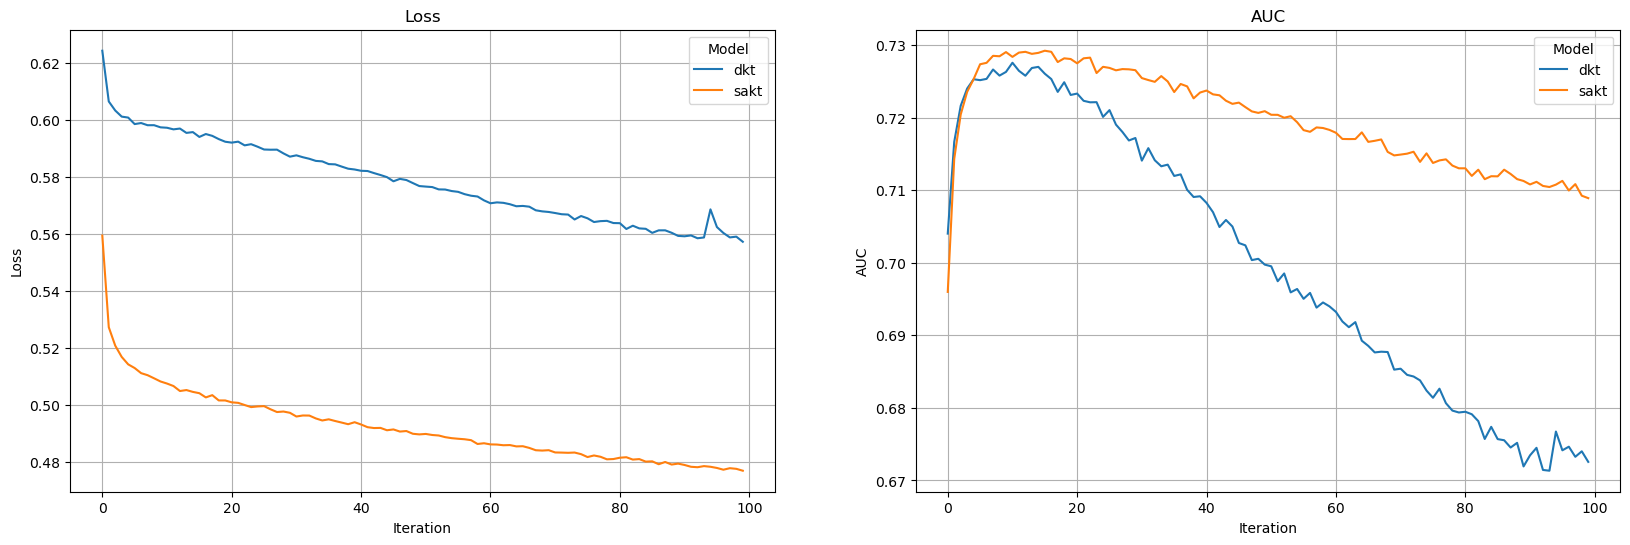

In [20]:
results_dict = {}
combined_df = None
for model_name in ["dkt", "dkvmn", "sakt"]:
    ckpt_dir = f"ckpts_precomputed/{model_name}/ASSIST2015"
    pkl_files = [f for f in os.listdir(ckpt_dir) if f.endswith(".pkl")]

    if len(pkl_files) == 0:
        continue

    results_dict[model_name] = {}

    for file in pkl_files:
        with open(os.path.join(ckpt_dir, file), "rb") as f:
            results_dict[model_name][os.path.splitext(file)[0]] = pickle.load(f)

    # Create DataFrames for plotting
    df = pd.DataFrame(
        {
            "Epoch": range(len(results_dict[model_name]["aucs"])),
            "AUC": results_dict[model_name]["aucs"],
            "Loss": results_dict[model_name]["loss_means"],
            "Model": model_name,
        }
    )

    if combined_df is None:
        combined_df = df
    else:
        combined_df = pd.concat([combined_df, df])

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot Loss
sns.lineplot(ax=axes[0], data=combined_df, x="Iteration", y="Loss", hue="Model")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid(True)

# Plot AUC
sns.lineplot(ax=axes[1], data=combined_df, x="Iteration", y="AUC", hue="Model")
axes[1].set_title("AUC")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("AUC")
axes[1].grid(True)

plt.show()